In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import numpy as np

from sklearn.naive_bayes import _BaseDiscreteNB, MultinomialNB
# import modules/downloads

import pandas as pd
import re

from sklearn.metrics import v_measure_score

from sklearn.metrics import f1_score

In [2]:
import pandas as pd

extra_paragraphs = pd.read_csv("./tidy_text_data.csv")
extra_paragraphs = extra_paragraphs[:1250]

train = pd.read_csv("./train.txt", sep=";")
train.columns = ["text","sentiment"]
test = pd.read_csv("./test.txt", sep=";")
test.columns = ["text","sentiment"]

train_text = train.text
extra_paragraphs_text = extra_paragraphs.text_new

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000, min_df=3, binary=True, 
                             stop_words="english")
X_supervised = vectorizer.fit_transform(train_text)
X_unsupervised = vectorizer.transform(extra_paragraphs_text)

X_supervised.shape, X_unsupervised.shape

X_test = vectorizer.transform(test.text)
test_sentiment = test.sentiment

In [3]:
import numpy as np
combined_X = np.concatenate((X_supervised.toarray(), X_unsupervised.toarray()), axis = 0)
combined_X.shape

(17249, 4885)

In [4]:
mask = np.arange(X_supervised.shape[0])

In [5]:
# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

topics = unique(train['sentiment'])
y_train = np.array([topics.index(k) for k in train['sentiment']],dtype=int)
y_test = np.array([topics.index(k) for k in test_sentiment],dtype=int)
combined_Y = np.concatenate((y_train, np.zeros(X_unsupervised.shape[0], dtype=int)), axis=0)
print(len(unique(combined_Y)))
# y_test.shape

6


In [6]:
from sklearn.naive_bayes import _BaseDiscreteNB, MultinomialNB

class SoftMultinomialNB(MultinomialNB):

    # Note y = numpy array of size n x k containing 
    # for each example n, the probability of it belonging to class k.
    
    def fit(self, X, y, sample_weight=None):        
      _, n_features = X.shape
      self.n_features_in_ = n_features 

      Y = y
      self.classes_ = np.arange(Y.shape[1])

      if sample_weight is not None:
          Y = Y.astype(np.float64, copy=False)
          sample_weight = np.asarray(sample_weight)
          sample_weight = np.atleast_2d(sample_weight)
          Y *= check_array(sample_weight).T

      class_prior = self.class_prior

      # Count raw events from data before updating the class log prior
      # and feature log probas
      n_effective_classes = Y.shape[1]

      self._init_counters(n_effective_classes, n_features)
      self._count(X, Y)
      alpha = self._check_alpha()
      self._update_feature_log_prob(alpha)
      self._update_class_log_prior(class_prior=class_prior)
      return self

In [12]:
def semisupervised_EM(init_model,k, X, y_true, mask, max_iters=200, soft=False,
                      return_model=False):
    '''
    Implements semi-supervised Hard or Soft EM model.
        - init_model is a function for initializing the SoftMultinomialNB model
            (hint: you are going to want to use this parameter later in the
             homework to initialize in a different model)
        - X is an (n x d) numpy array
        - y_true - 0/1 class labels defined previously.
        - mask - an array of size n containing True or False indicating if you
            are to use the true labels of that example or not.
        - soft - a boolean variable, which if true, performs soft EM and
            otherwise performs hard EM
        - return_model - specifies whether or not to return the NB classifier
    
    Return a list of size n, containing the class label (between 0 and k-1) of
    each item.
    '''
    n, d = X.shape
    X.shape
    temp = np.zeros((len(y_true),k))
    for i in range(temp.shape[0]):
        temp[i,y_true[i]] = 1
    
    m = init_model()
    x_train = X[mask]
    # y_train = y_true[mask]
    y_train_mat = temp[mask]
    m.fit(x_train, y_train_mat)
    y_hat = None
    for _ in tqdm(range(max_iters)):
        # E Step: predict the latent variables (y_hat) using the model
        newy_hat = m.predict_proba(X)
        if not soft:
            for i_soft in range(len(newy_hat)):
                bestindex = np.argmax(newy_hat[i_soft])
                newy_hat[i_soft,:] = 0
                newy_hat[i_soft, bestindex] = 1
        # converged, return model
        if (newy_hat == y_hat).all():
            if return_model:
                return newy_hat, m
            else: 
                return newy_hat
        y_hat = newy_hat
        #M Step: retrain the model using the latent variables
        y_hat[mask] = y_train_mat
        m.fit(X, y_hat)

    y_hat = m.predict(X)
    if return_model:
        return y_hat, m
    else:
        return y_hat

In [8]:
yhat, m_soft = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True, soft=True)

100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


[0 1 2 ... 5 1 0]
6
The f1 score of fully trained model = 0.8880947429311116
       topic  cluster  count
0      anger        0    107
1      anger        1   1988
2      anger        2      1
3      anger        3      1
4      anger        4     36
5      anger        5     26
6       fear        0    114
7       fear        1     58
8       fear        2      2
9       fear        3      5
10      fear        4   1709
11      fear        5     49
12       joy        0    111
13       joy        1     19
14       joy        2     52
15       joy        3     12
16       joy        4     47
17       joy        5   5121
18      love        0     19
19      love        1      6
20      love        2   1035
21      love        4      8
22      love        5    236
23   sadness        0   4491
24   sadness        1     34
25   sadness        2     10
26   sadness        3      7
27   sadness        4     47
28   sadness        5     76
29  surprise        0     54
30  surprise        1   

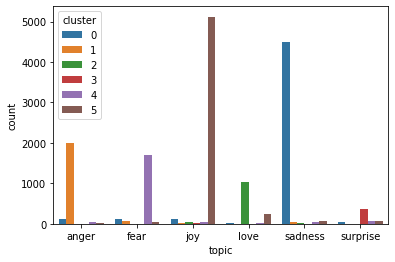

In [9]:
def breakdown_clusters_by_ground_truth(y_true, cluster_labels, display=True) :
    """
    If display = True, 
        display counts of documents of each topic in each of the generated
        clusters and plot the same.
        
    Returns v-measure of cluster labels with respect to ground truth
    """
    
    assert len(y_true) == len(cluster_labels), "Length of Target and cluster labels don't match"
    df = pd.DataFrame({'topic' : y_true, 'cluster' : cluster_labels})
    counts = df.groupby(['topic', 'cluster']).size().reset_index().rename(columns={0:'count'})
    if display :
        print(counts)
        sns.barplot(x="topic", y="count", hue="cluster", data=counts)
    return v_measure_score(y_true, cluster_labels)

from sklearn.metrics import f1_score

prediction_train = m_soft.predict(X_supervised)
print(prediction_train)
print(len(unique(prediction_train)))
train_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(train.sentiment, prediction_train, d)

print(f'The f1 score of fully trained model = {f1_score(y_train, prediction_train,average="macro")}')
print(f'The v-measure of fully trained model = {train_eval(prediction_train, d=True)}')

[0 0 4 ... 5 5 4]
6
The f1 score of fully trained model = 0.7329266095376865
       topic  cluster  count
0      anger        0     26
1      anger        1    217
2      anger        2      1
3      anger        3      1
4      anger        4     17
5      anger        5     13
6       fear        0     28
7       fear        1      8
8       fear        2      2
9       fear        3      1
10      fear        4    175
11      fear        5     10
12       joy        0     16
13       joy        1      4
14       joy        2     22
15       joy        3      3
16       joy        4     12
17       joy        5    638
18      love        0     13
19      love        1      6
20      love        2     87
21      love        4      2
22      love        5     51
23   sadness        0    517
24   sadness        1     11
25   sadness        2      5
26   sadness        3      1
27   sadness        4     18
28   sadness        5     28
29  surprise        0      9
30  surprise        1   

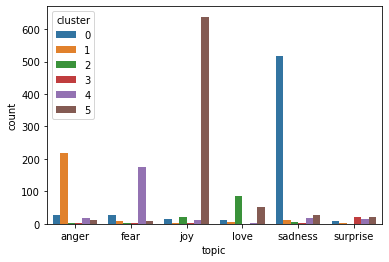

In [10]:
prediction_test = m_soft.predict(X_test)
print(prediction_test)
print(len(unique(prediction_test)))
test_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth( test_sentiment, prediction_test, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval(prediction_test, d=True)}')

100%|██████████| 200/200 [02:26<00:00,  1.36it/s]


[0 1 2 ... 5 5 0]
6
The f1 score of fully trained model = 0.8937319788053512
       topic  cluster  count
0      anger        0    109
1      anger        1   1978
2      anger        2      3
3      anger        3      1
4      anger        4     37
5      anger        5     31
6       fear        0     80
7       fear        1     40
8       fear        2      2
9       fear        3      4
10      fear        4   1777
11      fear        5     34
12       joy        0    124
13       joy        1     27
14       joy        2     61
15       joy        3      6
16       joy        4     24
17       joy        5   5120
18      love        0     20
19      love        1      7
20      love        2   1042
21      love        4      3
22      love        5    232
23   sadness        0   4496
24   sadness        1     39
25   sadness        2     11
26   sadness        3      5
27   sadness        4     28
28   sadness        5     86
29  surprise        0     46
30  surprise        1   

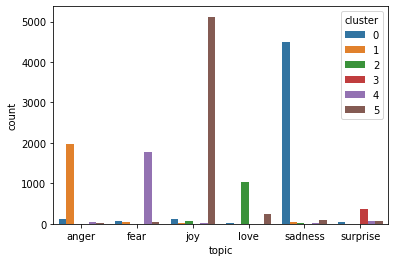

In [13]:
yhat_hard, m_hard = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True)
prediction_train_hard = m_hard.predict(X_supervised)
print(prediction_train_hard)
print(len(unique(prediction_train_hard)))
train_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(train.sentiment, prediction_train_hard, d)

print(f'The f1 score of fully trained model = {f1_score(y_train, prediction_train_hard,average="macro")}')
print(f'The v-measure of fully trained model = {train_eval(prediction_train_hard, d=True)}')


[0 0 5 ... 5 5 4]
6
The f1 score of fully trained model = 0.7429693433056285
       topic  cluster  count
0      anger        0     28
1      anger        1    218
2      anger        3      1
3      anger        4     13
4      anger        5     15
5       fear        0     28
6       fear        1      9
7       fear        2      1
8       fear        3      1
9       fear        4    172
10      fear        5     13
11       joy        0     14
12       joy        1      5
13       joy        2     22
14       joy        3      1
15       joy        4      6
16       joy        5    647
17      love        0     13
18      love        1      4
19      love        2     88
20      love        4      1
21      love        5     53
22   sadness        0    526
23   sadness        1     12
24   sadness        2      6
25   sadness        4      9
26   sadness        5     27
27  surprise        0      9
28  surprise        1      2
29  surprise        3     20
30  surprise        4   

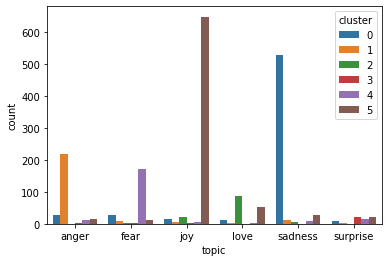

In [14]:
prediction_test_hard = m_hard.predict(X_test)
print(prediction_test_hard)
print(len(unique(prediction_test_hard)))
test_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth( test_sentiment, prediction_test_hard, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test_hard,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval(prediction_test_hard, d=True)}')